In [1]:
from sklearn.preprocessing import MinMaxScaler, minmax_scale, RobustScaler, StandardScaler, QuantileTransformer, Normalizer

In [2]:

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from env import user, password, host

#**************************************************Acquire*******************************************************

def acquire_zillow():
    ''' Acquire data from Zillow using env imports and rename columns'''
    
    url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
    query = """
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017

    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")"""

    # get dataframe of data
    df = pd.read_sql(query, url)
    
    
    # renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built',})
    return df

#**************************************************Remove Outliers*******************************************************

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

#**************************************************Distributions*******************************************************

def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()
        
        
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()
        
#**************************************************Prepare*******************************************************

def prepare_zillow(df):
    ''' Prepare zillow data for exploration'''

    # removing outliers
    df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount'])
    
    # get distributions of numeric data
    get_hist(df)
    get_box(df)
    
    # converting column datatypes
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)
    
    # drop taxamount
    df = df.drop(columns = 'taxamount')
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute year built using mode
    imputer = SimpleImputer(strategy='most_frequent')

    imputer.fit(train[['year_built']])

    train[['year_built']] = imputer.transform(train[['year_built']])
    validate[['year_built']] = imputer.transform(validate[['year_built']])
    test[['year_built']] = imputer.transform(test[['year_built']])       
    
    return train, validate, test    

#**************************************************Wrangle*******************************************************

def wrangle_zillow():
    '''Acquire and prepare data from Zillow database for explore'''
    train, validate, test = prepare_zillow(acquire_zillow())
    
    return train, validate, test

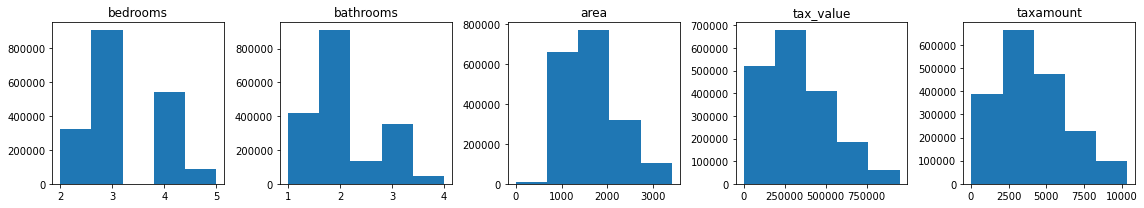

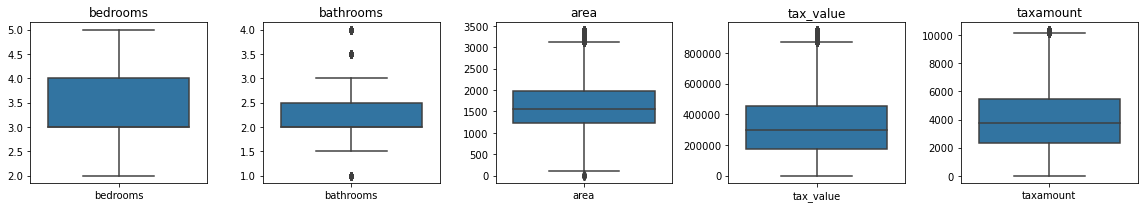

In [3]:
train, validate, test = wrangle_zillow()

In [4]:
# checking shape after data split

print(f'The shape of the train dataset is: {train.shape}')
print(f'The shape of the validate dataset is: {validate.shape}')
print(f'The shape of the test dataset is: {test.shape}')

The shape of the train dataset is: (1038959, 6)
The shape of the validate dataset is: (445269, 6)
The shape of the test dataset is: (371057, 6)


In [5]:
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,fips
10057,4.0,2.0,1561.0,248240.0,1973.0,6059.0
2004970,3.0,2.0,1770.0,88390.0,1960.0,6037.0
306031,2.0,1.0,1452.0,81169.0,1946.0,6037.0
1038595,3.0,1.0,1000.0,119174.0,1950.0,6037.0
270959,3.0,2.0,1974.0,432268.0,1988.0,6037.0


1. Apply the scalers we talked about in this lesson to your data and visualize the results for the unscaled and scaled distribution 

In [6]:
# use Min_max scaler

minmax_scaler = MinMaxScaler()

In [7]:
minmax_scaler.fit(train[['bedrooms', 'bathrooms', 'area']])

MinMaxScaler()

In [10]:
train[['bedrooms_minmax', 'bathrooms_minmax', 'area_minmax']] = minmax_scaler.transform(train[['bedrooms', 'bathrooms', 'area']])

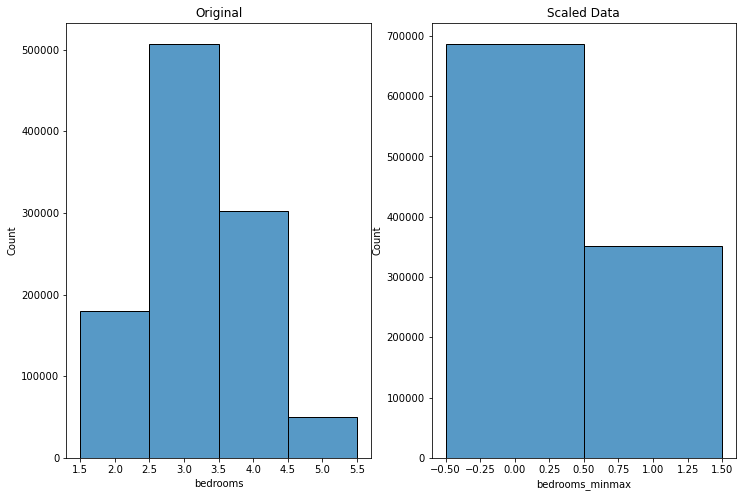

In [21]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.histplot(train.bedrooms, discrete = True).set(Title = "Original")

plt.subplot(122)
sns.histplot(train.bedrooms_minmax, discrete = True).set(Title = "Scaled Data")

plt.show()

In [22]:
train.bedrooms_minmax.head()

10057      0.666667
2004970    0.333333
306031     0.000000
1038595    0.333333
270959     0.333333
Name: bedrooms_minmax, dtype: float64

In [23]:
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,fips,bedrooms_minmax,bathrooms_minmax,area_minmax
10057,4.0,2.0,1561.0,248240.0,1973.0,6059.0,0.666667,0.333333,0.457612
2004970,3.0,2.0,1770.0,88390.0,1960.0,6037.0,0.333333,0.333333,0.518921
306031,2.0,1.0,1452.0,81169.0,1946.0,6037.0,0.000000,0.000000,0.425638
1038595,3.0,1.0,1000.0,119174.0,1950.0,6037.0,0.333333,0.000000,0.293048
270959,3.0,2.0,1974.0,432268.0,1988.0,6037.0,0.333333,0.333333,0.578762


2. Apply the .inverse_transform method to your scaled data. Is the resulting dataset the exact same as the original data?

In [ ]:
tax_value = minmax_scaler.inverse_transform(train[['_minmax']])

In [ ]:
train.head()

3. Read the documentation for sklearn's QuantileTransformer. Use normal for the output_distribution and apply this scaler to your data. Visualize the result of your data scaling.

In [ ]:
qt_scaler = QuantileTransformer(output_distribution='normal')
qt_scaler.fit(train[['']])

train['_qt'] = qt_scaler.transform(train[['']])

In [ ]:
plt.hist(x = train['tax_value_qt'])

4. Use the QuantileTransformer, but omit the output_distribution argument. Visualize your results. What do you notice?

In [ ]:
qt_scaler = QuantileTransformer()
qt_scaler.fit(train[['']])

train['_qt'] = qt_scaler.transform(train[['']])

In [ ]:
plt.hist(x = train['_qt'])

5. Based on the work you've done, choose a scaling method for your dataset. Write a function within your prepare.py that accepts as input the train, validate, and test data splits, and returns the scaled versions of each. Be sure to only learn the parameters for scaling from your training data!